# Model Training and Storing

In [4]:
from sklearn import svm, metrics
import tensorflow as tf
import numpy as np
import json
import pickle
import joblib

In [5]:
# Loading the MNIST dataset
mnist = tf.keras.datasets.mnist

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# x_train and x_test contain grayscale 28*28 images
# y_train and y_test contain the actual (ground truth) number (digit) that is in the picture

In [11]:
# We need to reshae the 28x28 images into 784-d vectors
x_train_flattened = x_train.reshape(60000,784)
x_test_flattened = x_test.reshape(10000,784)


In [12]:
# The script below can take up to 25 min to complete (more or less depending on resources)

# Create an SVM classifier
clf = svm.SVC(C=10, gamma=0.001, kernel="rbf", probability=True)

# Fit the model on training data
clf.fit(x_train_flattened, y_train)

# Predict (digit) on test data
predicted = clf.predict(x_test_flattened)

In [13]:
# Print a classification report
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(C=10, gamma=0.001, probability=True):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.93      0.94       892
           6       0.97      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.94      0.95       974
           9       0.96      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000




Confusion matrix:



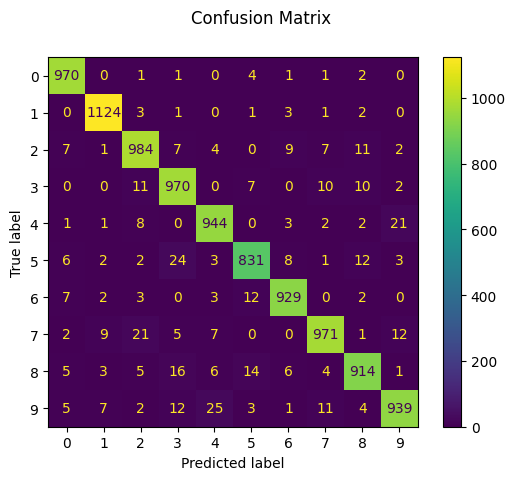

In [28]:
# Plot a confusion matrix
import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n")

plt.show()

In [15]:
# Store saved model
with open("./binaries/uncompressed_sklearn_mnist.pkl", "wb") as f:
    pickle.dump(clf, f)

In [16]:
# Compress and Store saved model
import joblib
joblib.dump(clf, "./binaries/sklearn_mnist.pkl", compress=3)

['./binaries/sklearn_mnist.pkl']

In [17]:
# To test that the saved model can be loaded and used for predictions, we proceed as follows:
model_from_saved_model = joblib.load(open("./binaries/sklearn_mnist.pkl", "rb"))
print("Sample prediction : ", model_from_saved_model.predict(x_test_flattened[:1]))
print("Sample probability: ", model_from_saved_model.predict_proba(x_test_flattened[:1]))

Sample prediction :  [7]
Sample probability:  [[2.73793244e-05 3.64177114e-06 7.88493210e-05 5.13563090e-03
  3.96850436e-06 3.18965359e-05 3.90185283e-07 9.94383033e-01
  1.78735760e-05 3.17336819e-04]]


# Input/Output Schema

In [18]:
input_schema = {
    "type": {
        "type": "array",
        "items": {
            "type": "array",
            "items": "float"
        }
    }
}

output_schema = {
    "name": "output_schema",
    "type": "record",
    "fields": [
        {
            "name": "predicted_probs",
            "type": {
                "type": "array",
                "items": "float"
            }
        },
        {
            "name": "score",
            "type": "int"
        }
    ]
}

with open("input_schema.avsc", "w") as f:
    json.dump(input_schema, f)
f.close()

with open("output_schema.avsc", "w") as f:
    json.dump(output_schema, f)
f.close()

# Model Script

In [19]:
import joblib
import numpy as np


def init() -> None:
    """
    A function to load pre-trained SVM model into a global variable
    """

    global model
    model = joblib.load(open("./binaries/sklearn_mnist.pkl", "rb"))


def predict(pixel_array: np.ndarray) -> dict:
    """
    A function to predict probabilities and assign digit to input image
    Args:
        pixel_array (np.ndarray): 28x28 numpy array (or List[List]), representing pixel
            values of a handwritten digit.

    Returns:
        (dict): Digit probabilities and most likely digit.
    """

    # Compute 10 probabilities, 1 for each possible digit
    predicted_probs = np.round(
        model.predict_proba(np.array([pixel_array]).ravel().reshape(1, -1)).tolist()[0]
    )

    # Add the best possible matching digit to the output
    score = np.argmax(predicted_probs)

    return {
        "predicted_probs": predicted_probs.tolist(), 
        "score": int(score)
    }


In [21]:
# Let's test the model by running the begin() function to load the saved model first, then calling
# the action function on a sample input image
init()

sample_score = predict(
    [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.0117647059,0.0705882353,0.0705882353,0.0705882353,0.4941176471,0.5333333333,0.6862745098,0.1019607843,0.6509803922,1.0,0.968627451,0.4980392157,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.1176470588,0.1411764706,0.368627451,0.6039215686,0.6666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.8823529412,0.6745098039,0.9921568627,0.9490196078,0.7647058824,0.2509803922,0,0,0,0],
        [0,0,0,0,0,0,0,0.1921568627,0.9333333333,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9843137255,0.3647058824,0.3215686275,0.3215686275,0.2196078431,0.1529411765,0,0,0,0,0],
        [0,0,0,0,0,0,0,0.0705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.7137254902,0.968627451,0.9450980392,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.3137254902,0.6117647059,0.4196078431,0.9921568627,0.9921568627,0.8039215686,0.0431372549,0,0.168627451,0.6039215686,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0.0549019608,0.0039215686,0.6039215686,0.9921568627,0.3529411765,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0.5450980392,0.9921568627,0.7450980392,0.0078431373,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0.0431372549,0.7450980392,0.9921568627,0.2745098039,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.137254902,0.9450980392,0.8823529412,0.6274509804,0.4235294118,0.0039215686,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0.3176470588,0.9411764706,0.9921568627,0.9921568627,0.4666666667,0.0980392157,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1764705882,0.7294117647,0.9921568627,0.9921568627,0.5882352941,0.1058823529,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.062745098,0.3647058824,0.9882352941,0.9921568627,0.7333333333,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9764705882,0.9921568627,0.9764705882,0.2509803922,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1803921569,0.5098039216,0.7176470588,0.9921568627,0.9921568627,0.8117647059,0.0078431373,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.1529411765,0.5803921569,0.8980392157,0.9921568627,0.9921568627,0.9921568627,0.9803921569,0.7137254902,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0.0941176471,0.4470588235,0.8666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7882352941,0.3058823529,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.0901960784,0.2588235294,0.8352941176,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.3176470588,0.0078431373,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0.0705882353,0.6705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7647058824,0.3137254902,0.0352941176,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0.2156862745,0.6745098039,0.8862745098,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9568627451,0.5215686275,0.0431372549,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0.5333333333,0.9921568627,0.9921568627,0.9921568627,0.831372549,0.5294117647,0.5176470588,0.062745098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    ]
)

In [22]:
# Here's the output dictionary
sample_score

{'predicted_probs': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'score': 5}

In [24]:
# predicting on sample from train dataset directly
predict(x_train_flattened[0])


{'predicted_probs': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'score': 5}

In [25]:
# Predicitng on a file of pixel arrays
with open("./data/sample_input.json", "r") as input:
    with open("./data/sample_output.json", "w") as output:
        for record in input:
            pixel_array = json.loads(record)["pixel_array"]
            model_output = predict(pixel_array)
            output.write(json.dumps(model_output))
            output.write("\n")